# Eye-Tracking Data Analysis for Point Cloud Viewing

This notebook analyzes eye-tracking data collected from users watching point clouds using the Velocity Threshold Identification (I-VT) algorithm.

## Data Structure
- JSON files: `GazeData_UserNN_PCName.json`
- Point cloud names: BlueSpin, CasualSquat, FlowerDance, ReadyForWinter
- Frame rate: 25 fps
- Initial 1.5 seconds discarded to account for erratical movements

In [1]:
# Import required libraries
import json
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from glob import glob
import warnings
warnings.filterwarnings('ignore')

# Set up plotting style - clean white background
plt.style.use('default')
sns.set_style("whitegrid")
sns.set_palette("husl")
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['axes.grid'] = False

# Create results directory
results_dir = "Eye-Tracking-Results"
os.makedirs(results_dir, exist_ok=True)

print("Libraries imported and results directory created successfully!")

/home/shivi/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


Libraries imported and results directory created successfully!


In [2]:
# Configuration parameters
FRAME_RATE = 25  # fps
INITIAL_DISCARD_TIME = 1.5  # seconds
INITIAL_DISCARD_FRAMES = int(INITIAL_DISCARD_TIME * FRAME_RATE)  # 37.5 frames

# I-VT algorithm parameters
VELOCITY_THRESHOLD_HEAD = 0.1  # m/s for head movement
VELOCITY_THRESHOLD_GAZE = 30   # degrees/s for gaze movement

# Color configuration for movement categories
CATEGORY_COLORS = {
    'Low': '#1f77b4',
    'Medium': '#2ca02c', 
    'High': '#ff7f0e'
}

# Category order for consistent plotting
CATEGORY_ORDER = ['Low', 'Medium', 'High']

print(f"Configuration:")
print(f"- Frame rate: {FRAME_RATE} fps")
print(f"- Initial discard: {INITIAL_DISCARD_TIME}s ({INITIAL_DISCARD_FRAMES} frames)")
print(f"- Head velocity threshold: {VELOCITY_THRESHOLD_HEAD} m/s")
print(f"- Gaze velocity threshold: {VELOCITY_THRESHOLD_GAZE} deg/s")
print(f"- Category colors: {CATEGORY_COLORS}")

Configuration:
- Frame rate: 25 fps
- Initial discard: 1.5s (37 frames)
- Head velocity threshold: 0.1 m/s
- Gaze velocity threshold: 30 deg/s
- Category colors: {'Low': '#1f77b4', 'Medium': '#2ca02c', 'High': '#ff7f0e'}


In [3]:
def load_eye_tracking_data(data_dir="Eye-Tracking-JSON"):
    """
    Load all eye-tracking JSON files from the specified directory.
    """
    all_data = []
    
    # Find all JSON files matching the pattern
    json_files = glob(os.path.join(data_dir, "GazeData_User*_*.json"))
    
    print(f"Found {len(json_files)} JSON files")
    
    for file_path in json_files:
        # Extract user ID and PC name from filename
        filename = os.path.basename(file_path)
        parts = filename.replace('.json', '').split('_')
        user_id = parts[1].replace('User', '')
        pc_name = parts[2]
        
        # Load JSON data
        try:
            with open(file_path, 'r') as f:
                lines = f.readlines()
                
            # Parse each line as JSON
            session_data = []
            for line in lines:
                if line.strip():
                    data_point = json.loads(line.strip())
                    session_data.append(data_point)
            
            # Convert to DataFrame and add metadata
            df = pd.DataFrame(session_data)
            corrected_user_id = int(user_id) - 51
            if corrected_user_id > 15:
                corrected_user_id -= 1
            corrected_user_id += 1
            df['user_id'] = corrected_user_id

            df['pc_name'] = pc_name
            df['frame_index'] = range(len(df))
            df['time_seconds'] = df['frame_index'] / FRAME_RATE
            
            # Remove initial frames
            df = df[df['frame_index'] >= INITIAL_DISCARD_FRAMES].copy()
            df = df.reset_index(drop=True)
            
            all_data.append(df)
            
        except Exception as e:
            print(f"Error loading {file_path}: {e}")
    
    # Combine all data
    combined_df = pd.concat(all_data, ignore_index=True)
    
    print(f"Loaded data for {combined_df['user_id'].nunique()} users")
    print(f"Point clouds: {combined_df['pc_name'].unique()}")
    print(f"Total data points after filtering: {len(combined_df)}")
    
    return combined_df

# Load the data
df = load_eye_tracking_data()
df.head()

Found 164 JSON files
Loaded data for 41 users
Point clouds: ['PCBlueSpin' 'PCCasualSquat' 'PCFlowerDance' 'PCReadyForWinter']
Total data points after filtering: 75594


,pcName,pcFrameIndex,gazeOriginX,gazeOriginY,gazeOriginZ,gazeDirectionNormalisedX,gazeDirectionNormalisedY,gazeDirectionNormalisedZ,pcWorldPositionX,pcWorldPositionY,pcWorldPositionZ,objectRotationY,userId,user_id,pc_name,frame_index,time_seconds
0,BlueSpin,36,0.364907,0.080448,0.237398,-0.062045,0.055913,0.996506,0.0,-1.5,2.2,90.0,51,1,PCBlueSpin,37,1.48
1,BlueSpin,37,0.365488,0.081867,0.238323,-0.130558,0.061773,0.989514,0.0,-1.5,2.2,90.0,51,1,PCBlueSpin,38,1.52
2,BlueSpin,38,0.365727,0.081866,0.238407,-0.131540,0.061959,0.989373,0.0,-1.5,2.2,90.0,51,1,PCBlueSpin,39,1.56
3,BlueSpin,39,0.366281,0.081813,0.238656,-0.134013,0.062498,0.989007,0.0,-1.5,2.2,90.0,51,1,PCBlueSpin,40,1.60
4,BlueSpin,40,0.366827,0.081719,0.238914,-0.136212,0.062915,0.988680,0.0,-1.5,2.2,90.0,51,1,PCBlueSpin,41,1.64


In [4]:
def calculate_movement_velocities(df):
    """
    Calculate head and gaze movement velocities using I-VT algorithm.
    """
    results = []
    
    # Process each user-PC combination separately
    for (user_id, pc_name), group in df.groupby(['user_id', 'pc_name']):
        group = group.sort_values('frame_index').reset_index(drop=True)
        
        # Calculate head position changes
        head_positions = group[['gazeOriginX', 'gazeOriginY', 'gazeOriginZ']].values
        head_diff = np.diff(head_positions, axis=0)
        head_distances = np.sqrt(np.sum(head_diff**2, axis=1))  # Euclidean distance in meters
        head_velocities = head_distances * FRAME_RATE  # Convert to m/s
        
        # Calculate gaze direction changes (angular velocity)
        gaze_directions = group[['gazeDirectionNormalisedX', 'gazeDirectionNormalisedY', 'gazeDirectionNormalisedZ']].values
        
        # Calculate angular differences between consecutive gaze vectors
        gaze_angular_diffs = []
        for i in range(1, len(gaze_directions)):
            v1 = gaze_directions[i-1]
            v2 = gaze_directions[i]
            # Normalize vectors
            v1_norm = v1 / np.linalg.norm(v1)
            v2_norm = v2 / np.linalg.norm(v2)
            # Calculate angle between vectors in radians
            dot_product = np.clip(np.dot(v1_norm, v2_norm), -1.0, 1.0)
            angle_rad = np.arccos(dot_product)
            angle_deg = np.degrees(angle_rad)
            gaze_angular_diffs.append(angle_deg)
        
        gaze_angular_velocities = np.array(gaze_angular_diffs) * FRAME_RATE  # Convert to deg/s
        
        # Create results for each second
        max_time = group['time_seconds'].max()
        
        for second in range(int(max_time) + 1):
            # Find frames in this second
            start_time = second
            end_time = second + 1
            
            mask = (group['time_seconds'] >= start_time) & (group['time_seconds'] < end_time)
            frames_in_second = np.where(mask)[0]
            
            if len(frames_in_second) > 1:
                # Get velocities for this second (excluding the first frame since we need differences)
                valid_head_indices = frames_in_second[frames_in_second > 0] - 1
                valid_gaze_indices = frames_in_second[frames_in_second > 0] - 1
                
                if len(valid_head_indices) > 0:
                    head_vel_second = np.mean(head_velocities[valid_head_indices])
                    gaze_vel_second = np.mean(gaze_angular_velocities[valid_gaze_indices])
                    
                    results.append({
                        'user_id': user_id,
                        'pc_name': pc_name,
                        'second': second,
                        'head_velocity_m_per_s': head_vel_second,
                        'gaze_velocity_deg_per_s': gaze_vel_second
                    })
    
    return pd.DataFrame(results)

# Calculate movement velocities
velocity_df = calculate_movement_velocities(df)
print(f"Calculated velocities for {len(velocity_df)} second-intervals")
print(f"Head velocity range: {velocity_df['head_velocity_m_per_s'].min():.4f} - {velocity_df['head_velocity_m_per_s'].max():.4f} m/s")
print(f"Gaze velocity range: {velocity_df['gaze_velocity_deg_per_s'].min():.4f} - {velocity_df['gaze_velocity_deg_per_s'].max():.4f} deg/s")

velocity_df.head()

Calculated velocities for 3103 second-intervals
Head velocity range: 0.0036 - 6.3352 m/s
Gaze velocity range: 0.5561 - 636.8716 deg/s


,user_id,pc_name,second,head_velocity_m_per_s,gaze_velocity_deg_per_s
0,1,PCBlueSpin,1,0.024504,13.242118
1,1,PCBlueSpin,2,0.250724,11.444521
2,1,PCBlueSpin,3,1.085552,83.126194
3,1,PCBlueSpin,4,0.234695,12.767400
4,1,PCBlueSpin,5,0.610607,37.148299


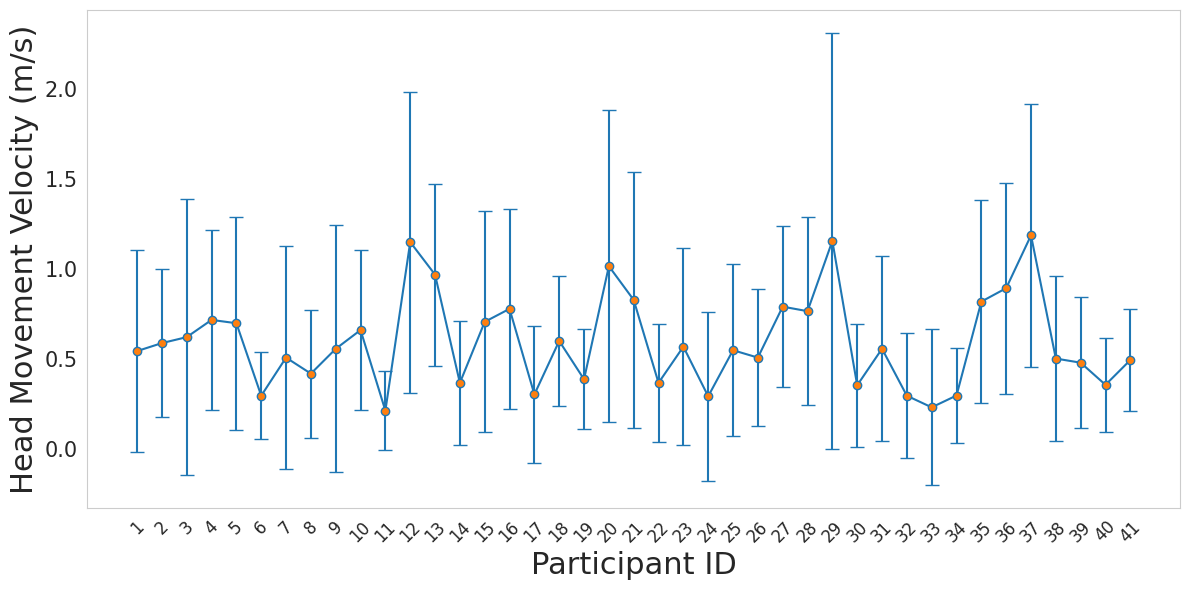

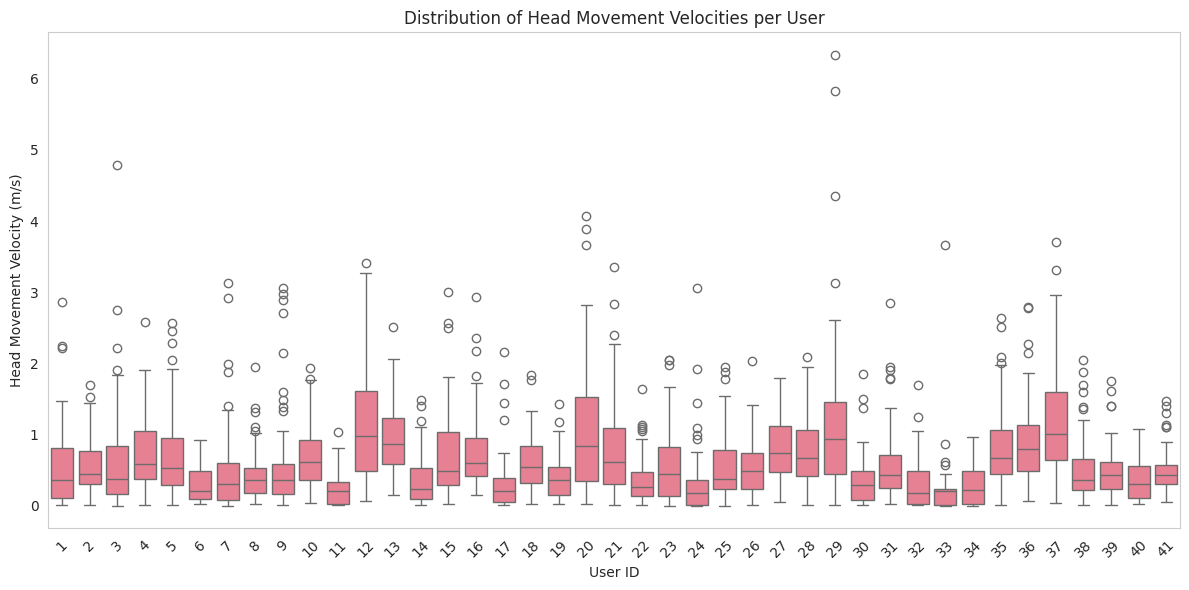

Head movement statistics:
Overall mean: 0.5958 ± 0.5876 m/s
Median: 0.4368 m/s


In [18]:
# Plot head movement per second - Average with error bars
plt.figure(figsize=(12, 6))
user_head_stats = velocity_df.groupby('user_id')['head_velocity_m_per_s'].agg(['mean', 'std']).reset_index()
plt.errorbar(range(len(user_head_stats)), user_head_stats['mean'], 
             yerr=user_head_stats['std'], fmt='o-', capsize=5, alpha=1.0, color="tab:blue", markerfacecolor="tab:orange")
plt.xlabel('Participant ID', fontsize="22")
plt.ylabel('Head Movement Velocity (m/s)', fontsize="22")
#plt.title('Average Head Movement Velocity per User (with std dev)')
plt.xticks(range(len(user_head_stats)), user_head_stats['user_id'], rotation=45, fontsize=12)
#plt.ylim(0, 2.5)  # Set y-axis limits
plt.yticks(fontsize=15)
plt.tight_layout()
plt.savefig(os.path.join(results_dir, 'head_movement_average.png'), dpi=300, bbox_inches='tight')
plt.show()

# Plot head movement per second - Distribution box plot
plt.figure(figsize=(12, 6))
sns.boxplot(data=velocity_df, x='user_id', y='head_velocity_m_per_s')
plt.xlabel('User ID')
plt.ylabel('Head Movement Velocity (m/s)')
plt.title('Distribution of Head Movement Velocities per User')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig(os.path.join(results_dir, 'head_movement_distribution.png'), dpi=300, bbox_inches='tight')
plt.show()

print(f"Head movement statistics:")
print(f"Overall mean: {velocity_df['head_velocity_m_per_s'].mean():.4f} ± {velocity_df['head_velocity_m_per_s'].std():.4f} m/s")
print(f"Median: {velocity_df['head_velocity_m_per_s'].median():.4f} m/s")

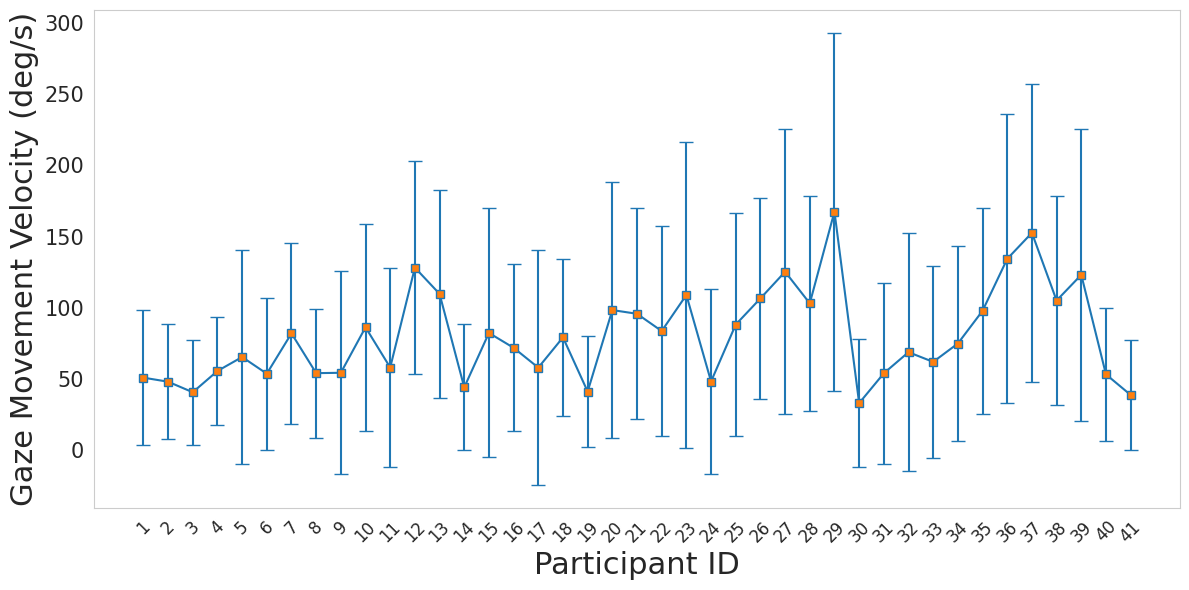

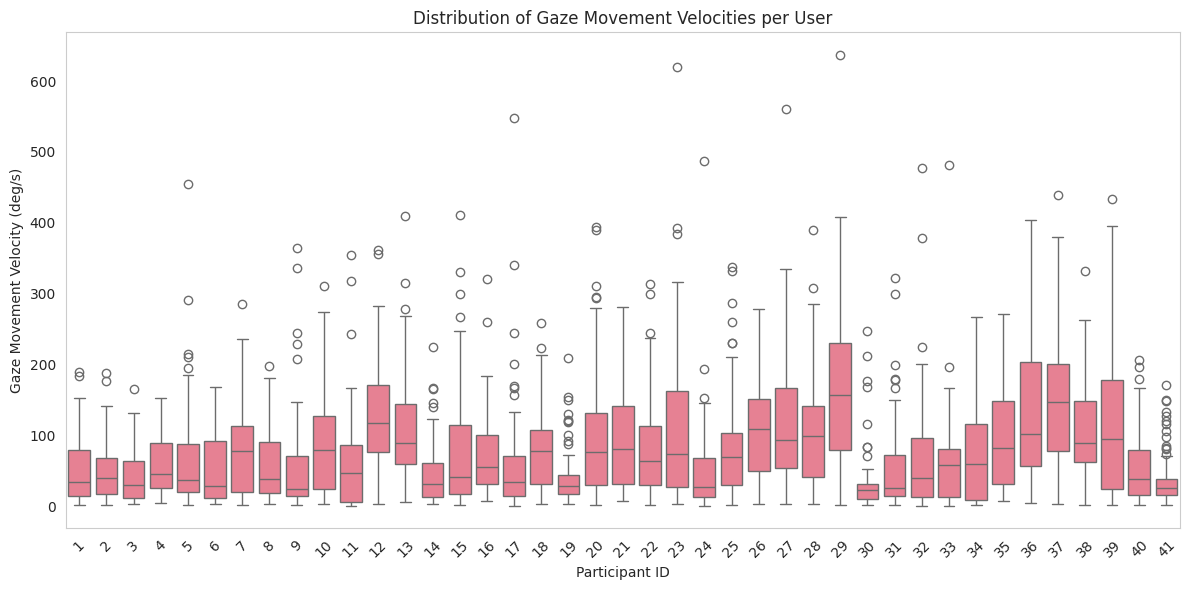

Gaze movement statistics:
Overall mean: 80.1821 ± 79.3844 deg/s
Median: 58.0778 deg/s


In [19]:
# Plot gaze movement per second - Average with error bars
plt.figure(figsize=(12, 6))
user_gaze_stats = velocity_df.groupby('user_id')['gaze_velocity_deg_per_s'].agg(['mean', 'std']).reset_index()
plt.errorbar(range(len(user_gaze_stats)), user_gaze_stats['mean'], 
             yerr=user_gaze_stats['std'], fmt='s-', capsize=5, alpha=1.0, color="tab:blue", markerfacecolor="tab:orange")
plt.xlabel('Participant ID', fontsize="22")
plt.ylabel('Gaze Movement Velocity (deg/s)', fontsize="22")
#plt.title('Average Gaze Movement Velocity per User (with std dev)')
plt.xticks(range(len(user_gaze_stats)), user_gaze_stats['user_id'], rotation=45, fontsize=12)
plt.yticks(fontsize=15)
plt.tight_layout()
plt.savefig(os.path.join(results_dir, 'gaze_movement_average.png'), dpi=300, bbox_inches='tight')
plt.show()

# Plot gaze movement per second - Distribution box plot
plt.figure(figsize=(12, 6))
sns.boxplot(data=velocity_df, x='user_id', y='gaze_velocity_deg_per_s')
plt.xlabel('Participant ID')
plt.ylabel('Gaze Movement Velocity (deg/s)')
plt.title('Distribution of Gaze Movement Velocities per User')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig(os.path.join(results_dir, 'gaze_movement_distribution.png'), dpi=300, bbox_inches='tight')
plt.show()

print(f"Gaze movement statistics:")
print(f"Overall mean: {velocity_df['gaze_velocity_deg_per_s'].mean():.4f} ± {velocity_df['gaze_velocity_deg_per_s'].std():.4f} deg/s")
print(f"Median: {velocity_df['gaze_velocity_deg_per_s'].median():.4f} deg/s")

In [7]:
def classify_users_by_movement(velocity_df):
    """
    Classify users into low, medium, high movement categories based on percentiles.
    """
    # Calculate average velocities per user
    user_stats = velocity_df.groupby('user_id').agg({
        'head_velocity_m_per_s': 'mean',
        'gaze_velocity_deg_per_s': 'mean'
    }).reset_index()
    
    # Calculate percentiles for head movement
    head_25th = np.percentile(user_stats['head_velocity_m_per_s'], 25)
    head_75th = np.percentile(user_stats['head_velocity_m_per_s'], 75)
    
    # Calculate percentiles for gaze movement
    gaze_25th = np.percentile(user_stats['gaze_velocity_deg_per_s'], 25)
    gaze_75th = np.percentile(user_stats['gaze_velocity_deg_per_s'], 75)
    
    # Classify based on head movement
    def classify_head_movement(vel):
        if vel <= head_25th:
            return 'Low'
        elif vel >= head_75th:
            return 'High'
        else:
            return 'Medium'
    
    # Classify based on gaze movement
    def classify_gaze_movement(vel):
        if vel <= gaze_25th:
            return 'Low'
        elif vel >= gaze_75th:
            return 'High'
        else:
            return 'Medium'
    
    user_stats['head_movement_category'] = user_stats['head_velocity_m_per_s'].apply(classify_head_movement)
    user_stats['gaze_movement_category'] = user_stats['gaze_velocity_deg_per_s'].apply(classify_gaze_movement)
    
    # Create combined category (using head movement as primary)
    user_stats['overall_movement_category'] = user_stats['head_movement_category']
    
    print(f"Head movement thresholds: Low ≤ {head_25th:.4f}, High ≥ {head_75th:.4f} m/s")
    print(f"Gaze movement thresholds: Low ≤ {gaze_25th:.4f}, High ≥ {gaze_75th:.4f} deg/s")
    
    print("\nUser classification by head movement:")
    print(user_stats['head_movement_category'].value_counts())
    
    print("\nUser classification by gaze movement:")
    print(user_stats['gaze_movement_category'].value_counts())
    
    # Analyze category overlap
    print("\nCategory overlap analysis:")
    overlap_analysis = user_stats.groupby(['head_movement_category', 'gaze_movement_category']).size().reset_index(name='count')
    print(overlap_analysis)
    
    # Check if same users are in same categories
    same_category_users = user_stats[user_stats['head_movement_category'] == user_stats['gaze_movement_category']]
    print(f"\nUsers with same head and gaze movement categories: {len(same_category_users)} out of {len(user_stats)} ({len(same_category_users)/len(user_stats)*100:.1f}%)")
    
    for category in CATEGORY_ORDER:
        head_users = set(user_stats[user_stats['head_movement_category'] == category]['user_id'])
        gaze_users = set(user_stats[user_stats['gaze_movement_category'] == category]['user_id'])
        overlap = head_users.intersection(gaze_users)
        print(f"{category} movement - Overlap: {len(overlap)}/{len(head_users)} head users are also {category} gaze users ({len(overlap)/len(head_users)*100:.1f}%)")
    
    return user_stats

# Classify users
user_classifications = classify_users_by_movement(velocity_df)
user_classifications.head(10)

Head movement thresholds: Low ≤ 0.3682, High ≥ 0.7664 m/s
Gaze movement thresholds: Low ≤ 54.0249, High ≥ 103.1452 deg/s

User classification by head movement:
head_movement_category
Medium    19
Low       11
High      11
Name: count, dtype: int64

User classification by gaze movement:
gaze_movement_category
Medium    19
Low       11
High      11
Name: count, dtype: int64

Category overlap analysis:
  head_movement_category gaze_movement_category  count
0                   High                   High      7
1                   High                 Medium      4
2                    Low                    Low      5
3                    Low                 Medium      6
4                 Medium                   High      4
5                 Medium                    Low      6
6                 Medium                 Medium      9

Users with same head and gaze movement categories: 21 out of 41 (51.2%)
Low movement - Overlap: 5/11 head users are also Low gaze users (45.5%)
Medium movem

,user_id,head_velocity_m_per_s,gaze_velocity_deg_per_s,head_movement_category,gaze_movement_category,overall_movement_category
0,1,0.544694,50.958005,Medium,Low,Medium
1,2,0.589066,48.103974,Medium,Low,Medium
2,3,0.622235,40.712053,Medium,Low,Medium
3,4,0.717912,55.632476,Medium,Medium,Medium
4,5,0.699409,65.447986,Medium,Medium,Medium
5,6,0.296695,53.739486,Low,Low,Low
6,7,0.508466,82.051589,Medium,Medium,Medium
7,8,0.419429,54.123054,Medium,Medium,Medium
8,9,0.557154,54.377103,Medium,Medium,Medium
9,10,0.661603,86.324443,Medium,Medium,Medium


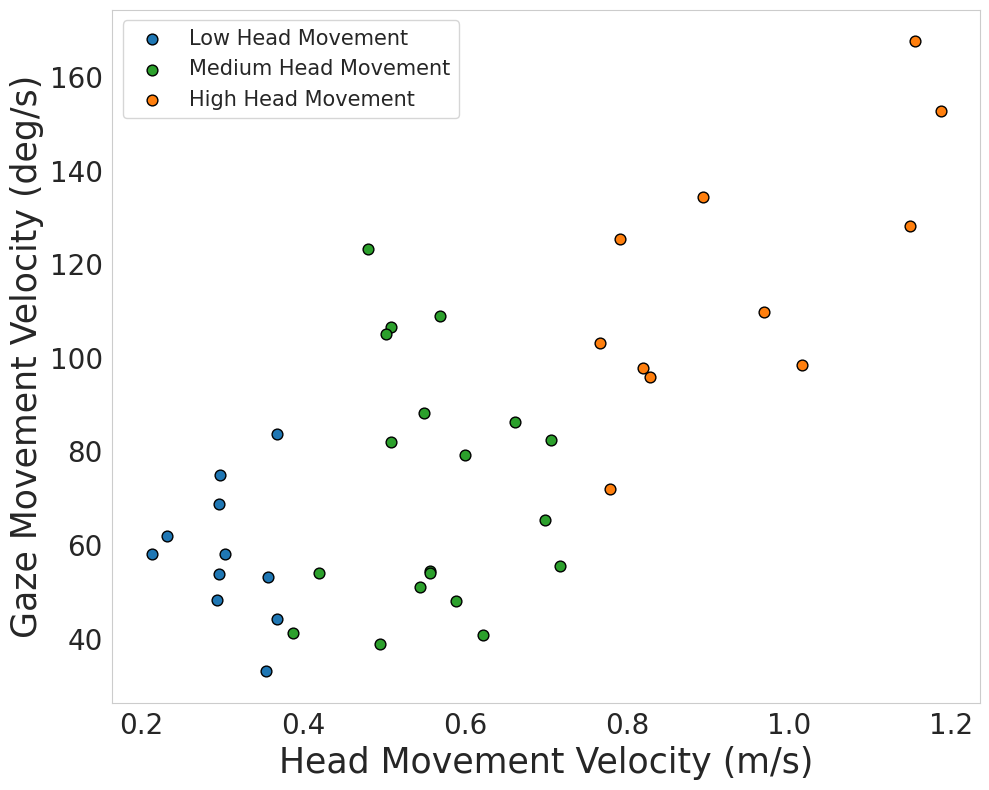

Average velocities by movement category:
Low Movement - Head: 0.3075 m/s, Gaze: 58.0 deg/s
Medium Movement - Head: 0.5620 m/s, Gaze: 71.9 deg/s
High Movement - Head: 0.9418 m/s, Gaze: 116.8 deg/s


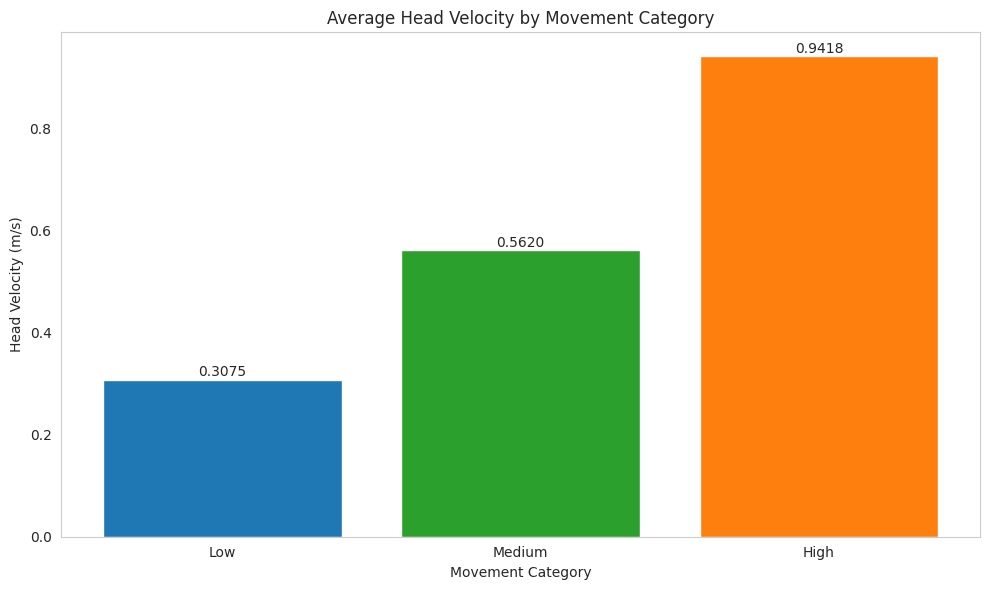

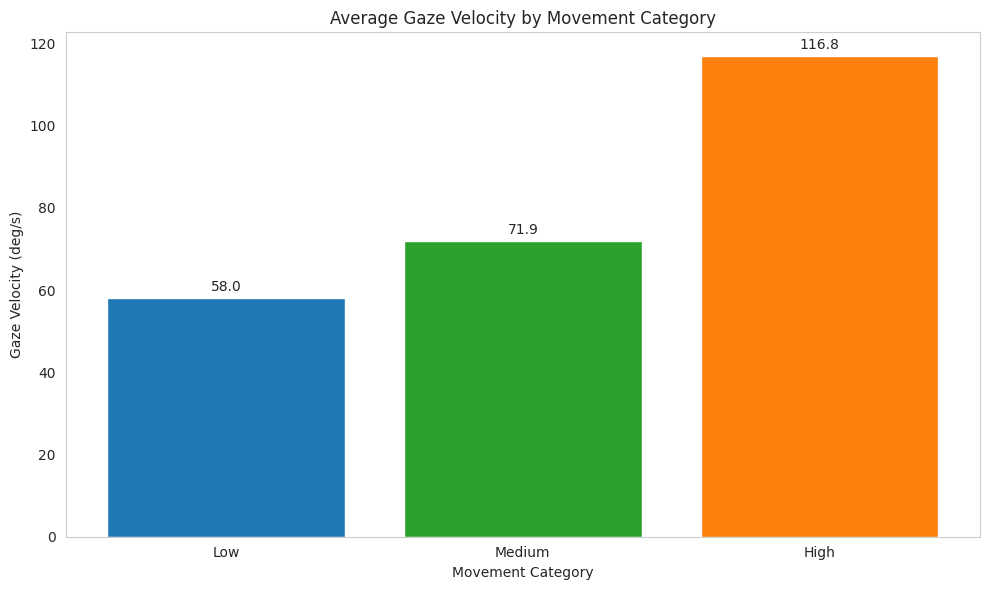

In [28]:
# Plot user movement classifications as bar charts

# Head movement classification bar chart
# plt.figure(figsize=(10, 6))
# head_counts = user_classifications['head_movement_category'].value_counts()
# # Reorder according to CATEGORY_ORDER
# head_counts_ordered = [head_counts.get(cat, 0) for cat in CATEGORY_ORDER]
# bars = plt.bar(CATEGORY_ORDER, head_counts_ordered, 
#                color=[CATEGORY_COLORS[cat] for cat in CATEGORY_ORDER], alpha=1.0)
# plt.xlabel('Movement Category')
# plt.ylabel('Number of Users')
# plt.title('Head Movement Classification\n(25th/75th Percentile Split)')
# # Add value labels on bars
# for bar, value in zip(bars, head_counts_ordered):
#     plt.text(bar.get_x() + bar.get_width()/2., bar.get_height() + 0.1,
#              f'{value}', ha='center', va='bottom', fontweight='bold')
# plt.tight_layout()
# plt.savefig(os.path.join(results_dir, 'head_movement_classification.png'), dpi=300, bbox_inches='tight')
# plt.show()

# Gaze movement classification bar chart
# plt.figure(figsize=(10, 6))
# gaze_counts = user_classifications['gaze_movement_category'].value_counts()
# # Reorder according to CATEGORY_ORDER
# gaze_counts_ordered = [gaze_counts.get(cat, 0) for cat in CATEGORY_ORDER]
# bars = plt.bar(CATEGORY_ORDER, gaze_counts_ordered, 
#                color=[CATEGORY_COLORS[cat] for cat in CATEGORY_ORDER], alpha=1.0)
# plt.xlabel('Movement Category')
# plt.ylabel('Number of Users')
# plt.title('Gaze Movement Classification\n(25th/75th Percentile Split)')
# # Add value labels on bars
# for bar, value in zip(bars, gaze_counts_ordered):
#     plt.text(bar.get_x() + bar.get_width()/2., bar.get_height() + 0.1,
#              f'{value}', ha='center', va='bottom', fontweight='bold')
# plt.tight_layout()
# plt.savefig(os.path.join(results_dir, 'gaze_movement_classification.png'), dpi=300, bbox_inches='tight')
# plt.show()

# Scatter plot of head vs gaze velocities with categories
plt.figure(figsize=(10, 8))
for category in CATEGORY_ORDER:
    subset = user_classifications[user_classifications['head_movement_category'] == category]
    plt.scatter(subset['head_velocity_m_per_s'], subset['gaze_velocity_deg_per_s'], 
                c=CATEGORY_COLORS[category], label=f'{category} Head Movement', alpha=1.0, s=60,
                edgecolors= "black")

plt.xlabel('Head Movement Velocity (m/s)', fontsize=25)
plt.ylabel('Gaze Movement Velocity (deg/s)',fontsize=25)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
#plt.title('Head vs Gaze Movement Velocities by Category')
plt.legend( fontsize=15)
plt.tight_layout()
plt.savefig(os.path.join(results_dir, 'head_vs_gaze_scatter.png'), dpi=300, bbox_inches='tight')
plt.show()

# Calculate average velocities by category for printing
category_stats = user_classifications.groupby('head_movement_category').agg({
    'head_velocity_m_per_s': 'mean',
    'gaze_velocity_deg_per_s': 'mean'
}).reset_index()

# Print average velocities
print("Average velocities by movement category:")
for category in CATEGORY_ORDER:
    if category in category_stats['head_movement_category'].values:
        head_vel = category_stats[category_stats['head_movement_category'] == category]['head_velocity_m_per_s'].iloc[0]
        gaze_vel = category_stats[category_stats['head_movement_category'] == category]['gaze_velocity_deg_per_s'].iloc[0]
        print(f"{category} Movement - Head: {head_vel:.4f} m/s, Gaze: {gaze_vel:.1f} deg/s")

# Split average velocities into separate bar charts
# Head velocity by category
plt.figure(figsize=(10, 6))
category_stats_ordered = category_stats.set_index('head_movement_category').reindex(CATEGORY_ORDER).reset_index()
bars1 = plt.bar(category_stats_ordered['head_movement_category'], 
                category_stats_ordered['head_velocity_m_per_s'], 
                color=[CATEGORY_COLORS[cat] for cat in category_stats_ordered['head_movement_category']], 
                alpha=1.0)
plt.xlabel('Movement Category')
plt.ylabel('Head Velocity (m/s)')
plt.title('Average Head Velocity by Movement Category')
# Add value labels on bars
for bar, value in zip(bars1, category_stats_ordered['head_velocity_m_per_s']):
    plt.text(bar.get_x() + bar.get_width()/2., bar.get_height() + 0.001,
             f'{value:.4f}', ha='center', va='bottom', fontsize=10)
plt.tight_layout()
#plt.savefig(os.path.join(results_dir, 'average_head_velocity_by_category.png'), dpi=300, bbox_inches='tight')
#plt.show()

# Gaze velocity by category
plt.figure(figsize=(10, 6))
bars2 = plt.bar(category_stats_ordered['head_movement_category'], 
                category_stats_ordered['gaze_velocity_deg_per_s'], 
                color=[CATEGORY_COLORS[cat] for cat in category_stats_ordered['head_movement_category']], 
                alpha=1.0)
plt.xlabel('Movement Category')
plt.ylabel('Gaze Velocity (deg/s)')
plt.title('Average Gaze Velocity by Movement Category')
# Add value labels on bars
for bar, value in zip(bars2, category_stats_ordered['gaze_velocity_deg_per_s']):
    plt.text(bar.get_x() + bar.get_width()/2., bar.get_height() + 1,
             f'{value:.1f}', ha='center', va='bottom', fontsize=10)
plt.tight_layout()
#plt.savefig(os.path.join(results_dir, 'average_gaze_velocity_by_category.png'), dpi=300, bbox_inches='tight')
#plt.show()

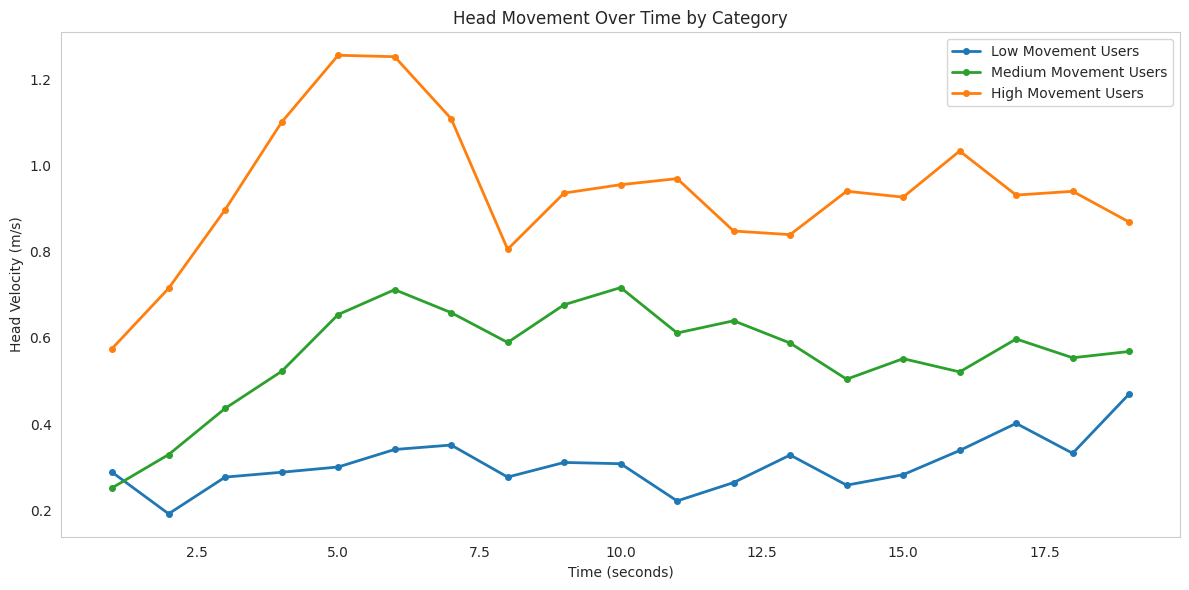

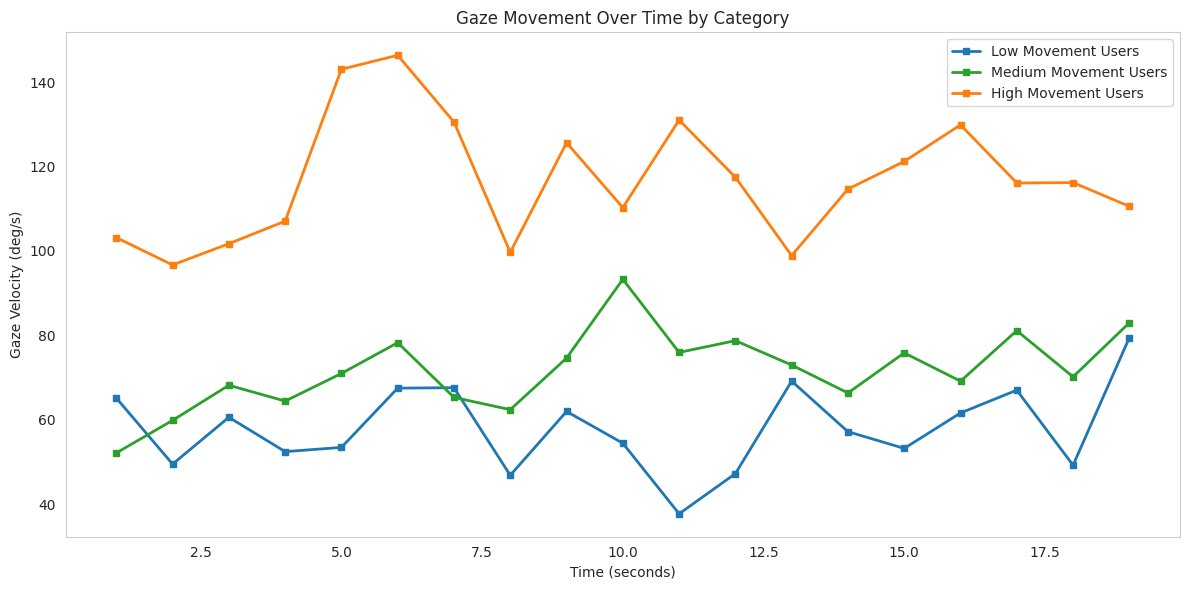

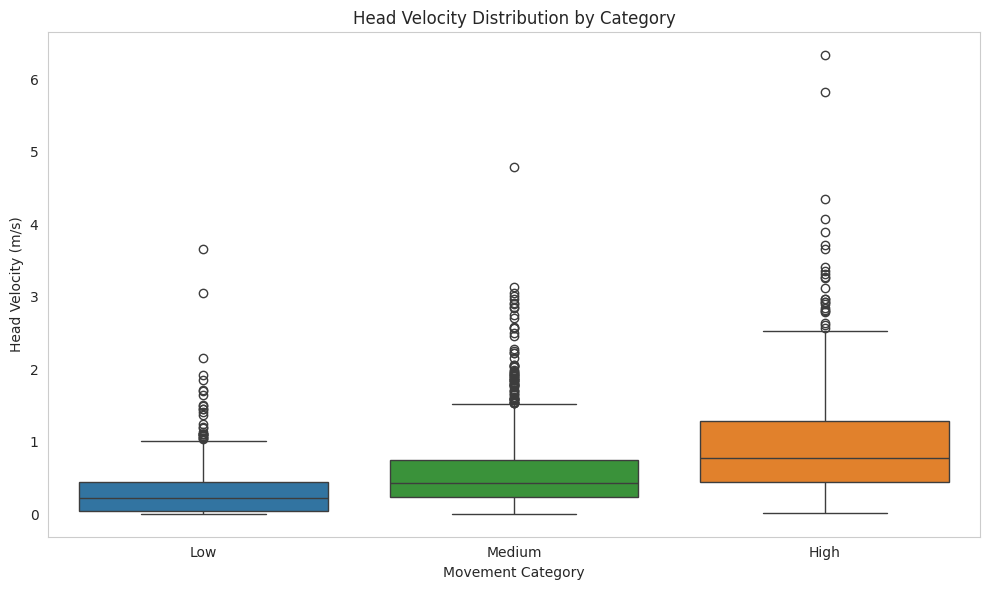

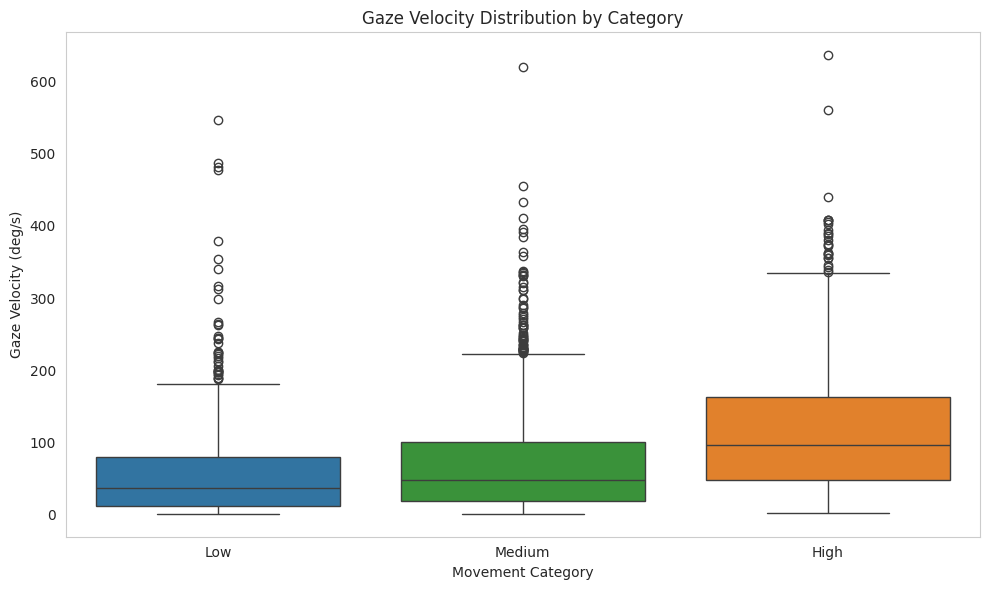

In [9]:
# Merge classifications back to velocity data
velocity_with_categories = velocity_df.merge(
    user_classifications[['user_id', 'head_movement_category', 'gaze_movement_category', 'overall_movement_category']], 
    on='user_id'
)

# Head movement by category over time
plt.figure(figsize=(12, 6))
category_time_head = velocity_with_categories.groupby(['overall_movement_category', 'second'])['head_velocity_m_per_s'].mean().reset_index()
for category in CATEGORY_ORDER:
    subset = category_time_head[category_time_head['overall_movement_category'] == category]
    plt.plot(subset['second'], subset['head_velocity_m_per_s'], 
             label=f'{category} Movement Users', linewidth=2, marker='o', markersize=4, 
             color=CATEGORY_COLORS[category], alpha=1.0)

plt.xlabel('Time (seconds)')
plt.ylabel('Head Velocity (m/s)')
plt.title('Head Movement Over Time by Category')
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(results_dir, 'head_movement_over_time_by_category.png'), dpi=300, bbox_inches='tight')
plt.show()

# Gaze movement by category over time
plt.figure(figsize=(12, 6))
category_time_gaze = velocity_with_categories.groupby(['overall_movement_category', 'second'])['gaze_velocity_deg_per_s'].mean().reset_index()
for category in CATEGORY_ORDER:
    subset = category_time_gaze[category_time_gaze['overall_movement_category'] == category]
    plt.plot(subset['second'], subset['gaze_velocity_deg_per_s'], 
             label=f'{category} Movement Users', linewidth=2, marker='s', markersize=4,
             color=CATEGORY_COLORS[category], alpha=1.0)

plt.xlabel('Time (seconds)')
plt.ylabel('Gaze Velocity (deg/s)')
plt.title('Gaze Movement Over Time by Category')
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(results_dir, 'gaze_movement_over_time_by_category.png'), dpi=300, bbox_inches='tight')
plt.show()

# Head velocity distribution by category - Box plots
plt.figure(figsize=(10, 6))
# Ensure proper ordering
velocity_with_categories['overall_movement_category'] = pd.Categorical(
    velocity_with_categories['overall_movement_category'], 
    categories=CATEGORY_ORDER, 
    ordered=True
)
sns.boxplot(data=velocity_with_categories, x='overall_movement_category', y='head_velocity_m_per_s',
           palette=[CATEGORY_COLORS[cat] for cat in CATEGORY_ORDER])
plt.xlabel('Movement Category')
plt.ylabel('Head Velocity (m/s)')
plt.title('Head Velocity Distribution by Category')
plt.tight_layout()
plt.savefig(os.path.join(results_dir, 'head_velocity_distribution_by_category.png'), dpi=300, bbox_inches='tight')
plt.show()

# Gaze velocity distribution by category - Box plots
plt.figure(figsize=(10, 6))
sns.boxplot(data=velocity_with_categories, x='overall_movement_category', y='gaze_velocity_deg_per_s',
           palette=[CATEGORY_COLORS[cat] for cat in CATEGORY_ORDER])
plt.xlabel('Movement Category')
plt.ylabel('Gaze Velocity (deg/s)')
plt.title('Gaze Velocity Distribution by Category')
plt.tight_layout()
plt.savefig(os.path.join(results_dir, 'gaze_velocity_distribution_by_category.png'), dpi=300, bbox_inches='tight')
plt.show()

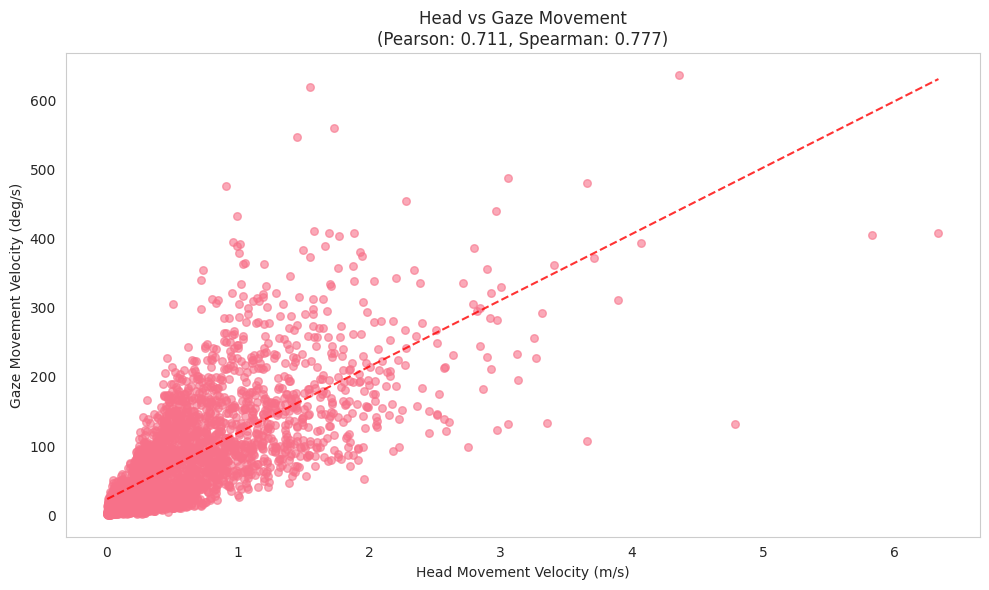

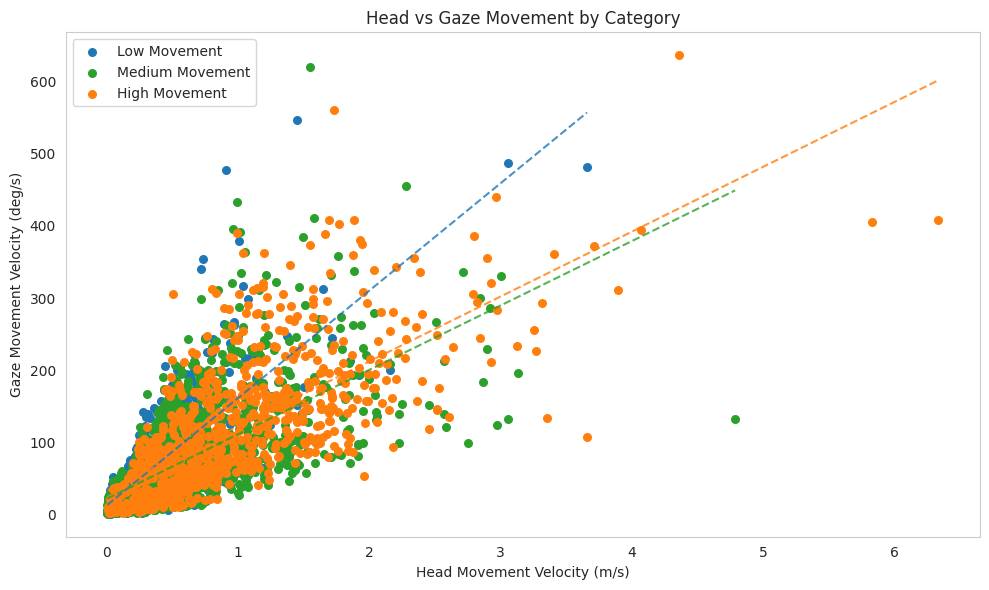

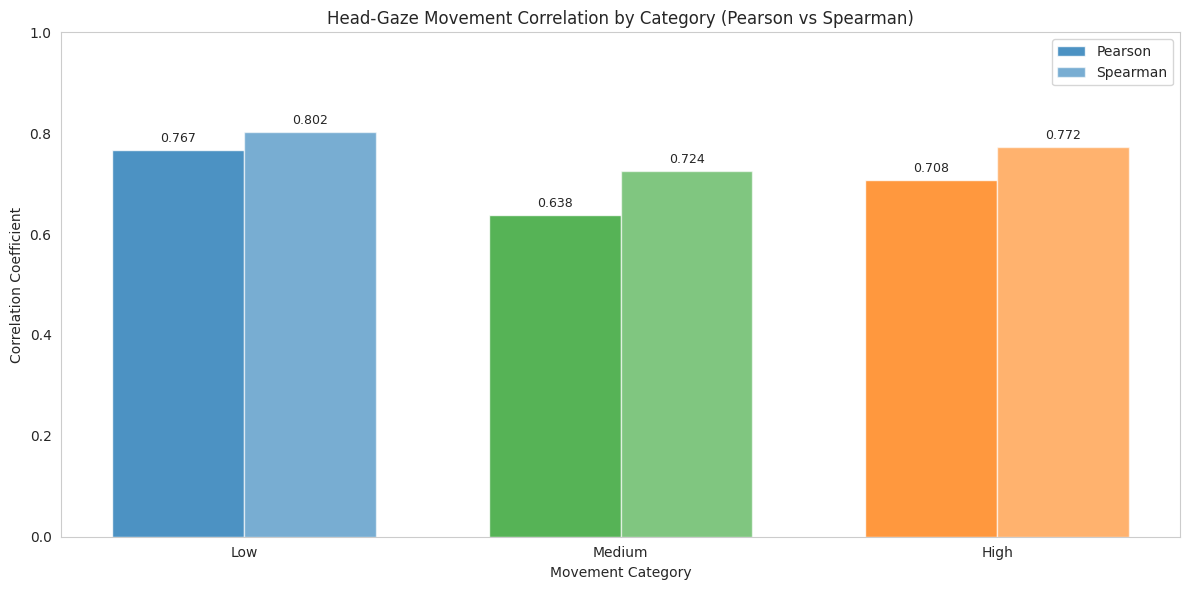

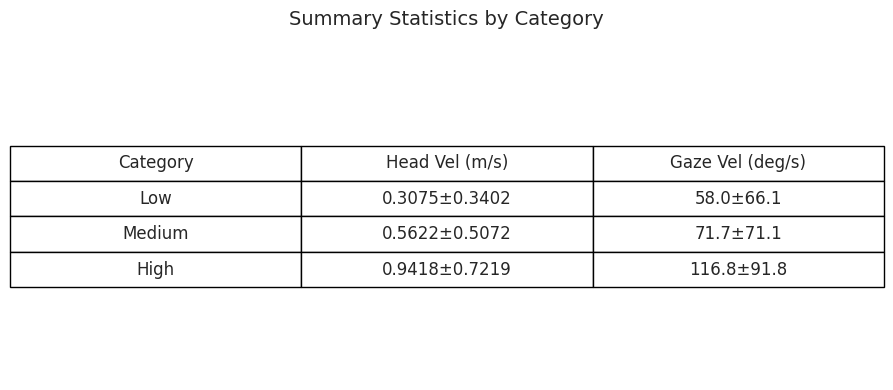

Correlation Analysis:
Overall Pearson correlation: 0.7105 (p=0.000000)
Overall Spearman correlation: 0.7775 (p=0.000000)

By category:
Low movement users - Pearson: 0.7672, Spearman: 0.8019
Medium movement users - Pearson: 0.6378, Spearman: 0.7244
High movement users - Pearson: 0.7076, Spearman: 0.7718


In [10]:
# Head movement vs Gaze direction change analysis
from scipy.stats import pearsonr, spearmanr

# Overall correlation scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(velocity_df['head_velocity_m_per_s'], velocity_df['gaze_velocity_deg_per_s'], 
           alpha=0.6, s=30)
# Add correlation line
z = np.polyfit(velocity_df['head_velocity_m_per_s'], velocity_df['gaze_velocity_deg_per_s'], 1)
p = np.poly1d(z)
plt.plot(velocity_df['head_velocity_m_per_s'].sort_values(), 
         p(velocity_df['head_velocity_m_per_s'].sort_values()), "r--", alpha=0.8)

# Calculate both correlations
pearson_corr, pearson_p = pearsonr(velocity_df['head_velocity_m_per_s'], velocity_df['gaze_velocity_deg_per_s'])
spearman_corr, spearman_p = spearmanr(velocity_df['head_velocity_m_per_s'], velocity_df['gaze_velocity_deg_per_s'])

plt.xlabel('Head Movement Velocity (m/s)')
plt.ylabel('Gaze Movement Velocity (deg/s)')
plt.title(f'Head vs Gaze Movement\n(Pearson: {pearson_corr:.3f}, Spearman: {spearman_corr:.3f})')
plt.tight_layout()
plt.savefig(os.path.join(results_dir, 'head_vs_gaze_overall_correlation.png'), dpi=300, bbox_inches='tight')
plt.show()

# Head vs gaze by movement category
plt.figure(figsize=(10, 6))
for category in CATEGORY_ORDER:
    subset = velocity_with_categories[velocity_with_categories['overall_movement_category'] == category]
    plt.scatter(subset['head_velocity_m_per_s'], subset['gaze_velocity_deg_per_s'], 
               c=CATEGORY_COLORS[category], label=f'{category} Movement', alpha=1.0, s=30)
    
    # Add correlation line for each category
    if len(subset) > 1:
        z = np.polyfit(subset['head_velocity_m_per_s'], subset['gaze_velocity_deg_per_s'], 1)
        p = np.poly1d(z)
        x_sorted = subset['head_velocity_m_per_s'].sort_values()
        plt.plot(x_sorted, p(x_sorted), color=CATEGORY_COLORS[category], linestyle='--', alpha=0.8)

plt.xlabel('Head Movement Velocity (m/s)')
plt.ylabel('Gaze Movement Velocity (deg/s)')
plt.title('Head vs Gaze Movement by Category')
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(results_dir, 'head_vs_gaze_by_category.png'), dpi=300, bbox_inches='tight')
plt.show()

# Correlation analysis by category - Bar chart
plt.figure(figsize=(12, 6))
pearson_correlations = []
spearman_correlations = []
categories = []

for category in CATEGORY_ORDER:
    subset = velocity_with_categories[velocity_with_categories['overall_movement_category'] == category]
    if len(subset) > 1:
        pearson_corr_cat, _ = pearsonr(subset['head_velocity_m_per_s'], subset['gaze_velocity_deg_per_s'])
        spearman_corr_cat, _ = spearmanr(subset['head_velocity_m_per_s'], subset['gaze_velocity_deg_per_s'])
        pearson_correlations.append(pearson_corr_cat)
        spearman_correlations.append(spearman_corr_cat)
        categories.append(category)

x = np.arange(len(categories))
width = 0.35

bars1 = plt.bar(x - width/2, pearson_correlations, width, 
               color=[CATEGORY_COLORS[cat] for cat in categories], 
               alpha=0.8, label='Pearson')
bars2 = plt.bar(x + width/2, spearman_correlations, width,
               color=[CATEGORY_COLORS[cat] for cat in categories], 
               alpha=0.6, label='Spearman')

plt.ylabel('Correlation Coefficient')
plt.xlabel('Movement Category')
plt.title('Head-Gaze Movement Correlation by Category (Pearson vs Spearman)')
plt.xticks(x, categories)
plt.legend()
plt.ylim(0, 1)

# Add value labels on bars
for bar, corr in zip(bars1, pearson_correlations):
    plt.text(bar.get_x() + bar.get_width()/2., bar.get_height() + 0.01,
             f'{corr:.3f}', ha='center', va='bottom', fontsize=9)
for bar, corr in zip(bars2, spearman_correlations):
    plt.text(bar.get_x() + bar.get_width()/2., bar.get_height() + 0.01,
             f'{corr:.3f}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.savefig(os.path.join(results_dir, 'correlation_by_category.png'), dpi=300, bbox_inches='tight')
plt.show()

# Summary statistics table
plt.figure(figsize=(10, 4))
summary_stats = velocity_with_categories.groupby('overall_movement_category').agg({
    'head_velocity_m_per_s': ['mean', 'std'],
    'gaze_velocity_deg_per_s': ['mean', 'std']
}).round(4)

table_data = []
for category in CATEGORY_ORDER:
    if category in summary_stats.index:
        head_mean = summary_stats.loc[category, ('head_velocity_m_per_s', 'mean')]
        head_std = summary_stats.loc[category, ('head_velocity_m_per_s', 'std')]
        gaze_mean = summary_stats.loc[category, ('gaze_velocity_deg_per_s', 'mean')]
        gaze_std = summary_stats.loc[category, ('gaze_velocity_deg_per_s', 'std')]
        
        table_data.append([category, f'{head_mean:.4f}±{head_std:.4f}', f'{gaze_mean:.1f}±{gaze_std:.1f}'])

plt.axis('tight')
plt.axis('off')
table = plt.table(cellText=table_data,
                 colLabels=['Category', 'Head Vel (m/s)', 'Gaze Vel (deg/s)'],
                 cellLoc='center',
                 loc='center')
table.auto_set_font_size(False)
table.set_fontsize(12)
table.scale(1.5, 2)
plt.title('Summary Statistics by Category', pad=20, fontsize=14)
plt.tight_layout()
plt.savefig(os.path.join(results_dir, 'summary_statistics_table.png'), dpi=300, bbox_inches='tight')
plt.show()

# Print correlation statistics
print("Correlation Analysis:")
print(f"Overall Pearson correlation: {pearson_corr:.4f} (p={pearson_p:.6f})")
print(f"Overall Spearman correlation: {spearman_corr:.4f} (p={spearman_p:.6f})")
print("\nBy category:")
for category, pearson_corr_cat, spearman_corr_cat in zip(categories, pearson_correlations, spearman_correlations):
    print(f"{category} movement users - Pearson: {pearson_corr_cat:.4f}, Spearman: {spearman_corr_cat:.4f}")

In [11]:
# Analysis by point cloud type
pc_analysis = velocity_df.groupby('pc_name').agg({
    'head_velocity_m_per_s': ['mean', 'std', 'count'],
    'gaze_velocity_deg_per_s': ['mean', 'std', 'count']
}).round(4)

print("Movement Analysis by Point Cloud Type:")
print("\nHead Movement (m/s):")
for pc_name in velocity_df['pc_name'].unique():
    head_mean = pc_analysis.loc[pc_name, ('head_velocity_m_per_s', 'mean')]
    head_std = pc_analysis.loc[pc_name, ('head_velocity_m_per_s', 'std')]
    count = pc_analysis.loc[pc_name, ('head_velocity_m_per_s', 'count')]
    print(f"{pc_name}: {head_mean:.4f} ± {head_std:.4f} m/s (n={count})")

print("\nGaze Movement (deg/s):")
for pc_name in velocity_df['pc_name'].unique():
    gaze_mean = pc_analysis.loc[pc_name, ('gaze_velocity_deg_per_s', 'mean')]
    gaze_std = pc_analysis.loc[pc_name, ('gaze_velocity_deg_per_s', 'std')]
    count = pc_analysis.loc[pc_name, ('gaze_velocity_deg_per_s', 'count')]
    print(f"{pc_name}: {gaze_mean:.1f} ± {gaze_std:.1f} deg/s (n={count})")

# Statistical testing
from scipy.stats import f_oneway

# ANOVA for head movement across point clouds
pc_groups_head = [velocity_df[velocity_df['pc_name'] == pc]['head_velocity_m_per_s'].values 
                  for pc in velocity_df['pc_name'].unique()]
f_stat_head, p_val_head = f_oneway(*pc_groups_head)

# ANOVA for gaze movement across point clouds
pc_groups_gaze = [velocity_df[velocity_df['pc_name'] == pc]['gaze_velocity_deg_per_s'].values 
                  for pc in velocity_df['pc_name'].unique()]
f_stat_gaze, p_val_gaze = f_oneway(*pc_groups_gaze)

print(f"\nANOVA Results:")
print(f"Head movement across point clouds: F={f_stat_head:.4f}, p={p_val_head:.6f}")
print(f"Gaze movement across point clouds: F={f_stat_gaze:.4f}, p={p_val_gaze:.6f}")

if p_val_head < 0.05:
    print("Significant difference in head movement between point clouds!")
else:
    print("No significant difference in head movement between point clouds.")
    
if p_val_gaze < 0.05:
    print("Significant difference in gaze movement between point clouds!")
else:
    print("No significant difference in gaze movement between point clouds.")



Movement Analysis by Point Cloud Type:

Head Movement (m/s):
PCBlueSpin: 0.5523 ± 0.5604 m/s (n=779)
PCCasualSquat: 0.7171 ± 0.6759 m/s (n=779)
PCFlowerDance: 0.5573 ± 0.5034 m/s (n=779)
PCReadyForWinter: 0.5559 ± 0.5814 m/s (n=766)

Gaze Movement (deg/s):
PCBlueSpin: 76.7 ± 74.6 deg/s (n=779)
PCCasualSquat: 95.6 ± 83.1 deg/s (n=779)
PCFlowerDance: 76.5 ± 77.8 deg/s (n=779)
PCReadyForWinter: 71.8 ± 79.8 deg/s (n=766)

ANOVA Results:
Head movement across point clouds: F=14.9912, p=0.000000
Gaze movement across point clouds: F=13.8855, p=0.000000
Significant difference in head movement between point clouds!
Significant difference in gaze movement between point clouds!


In [12]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd
hm_tukey = pairwise_tukeyhsd(velocity_df['head_velocity_m_per_s'], velocity_df['pc_name'])
print("Head Movement Tukey")
print(hm_tukey)

Head Movement Tukey
         Multiple Comparison of Means - Tukey HSD, FWER=0.05         
    group1         group2      meandiff p-adj   lower   upper  reject
---------------------------------------------------------------------
   PCBlueSpin    PCCasualSquat   0.1648    0.0  0.0888  0.2408   True
   PCBlueSpin    PCFlowerDance   0.0049 0.9983 -0.0711   0.081  False
   PCBlueSpin PCReadyForWinter   0.0035 0.9994 -0.0728  0.0799  False
PCCasualSquat    PCFlowerDance  -0.1599    0.0 -0.2359 -0.0838   True
PCCasualSquat PCReadyForWinter  -0.1613    0.0 -0.2376 -0.0849   True
PCFlowerDance PCReadyForWinter  -0.0014    1.0 -0.0777  0.0749  False
---------------------------------------------------------------------


In [13]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd
gm_tukey = pairwise_tukeyhsd(velocity_df['gaze_velocity_deg_per_s'], velocity_df['pc_name'])
print("Gaze Movement Tukey")
print(gm_tukey)

Gaze Movement Tukey
          Multiple Comparison of Means - Tukey HSD, FWER=0.05          
    group1         group2      meandiff p-adj   lower    upper   reject
-----------------------------------------------------------------------
   PCBlueSpin    PCCasualSquat  18.8532    0.0   8.5779  29.1286   True
   PCBlueSpin    PCFlowerDance  -0.2538 0.9999 -10.5291  10.0216  False
   PCBlueSpin PCReadyForWinter   -4.985 0.6002 -15.3039   5.3338  False
PCCasualSquat    PCFlowerDance  -19.107    0.0 -29.3823  -8.8316   True
PCCasualSquat PCReadyForWinter -23.8383    0.0 -34.1571 -13.5194   True
PCFlowerDance PCReadyForWinter  -4.7313 0.6405 -15.0501   5.5876  False
-----------------------------------------------------------------------


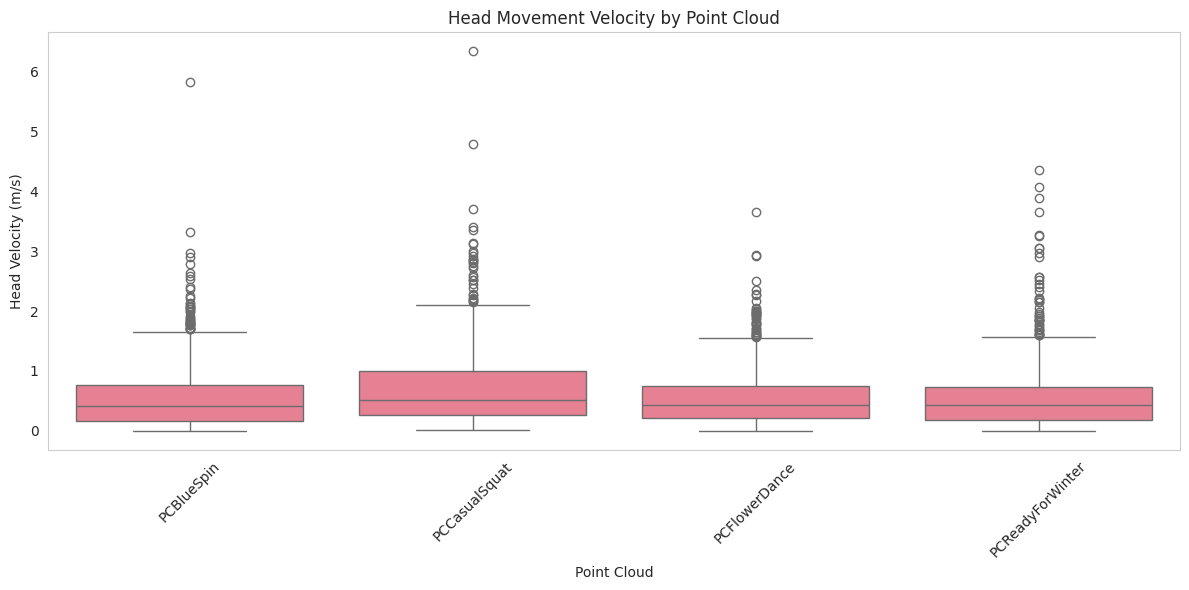

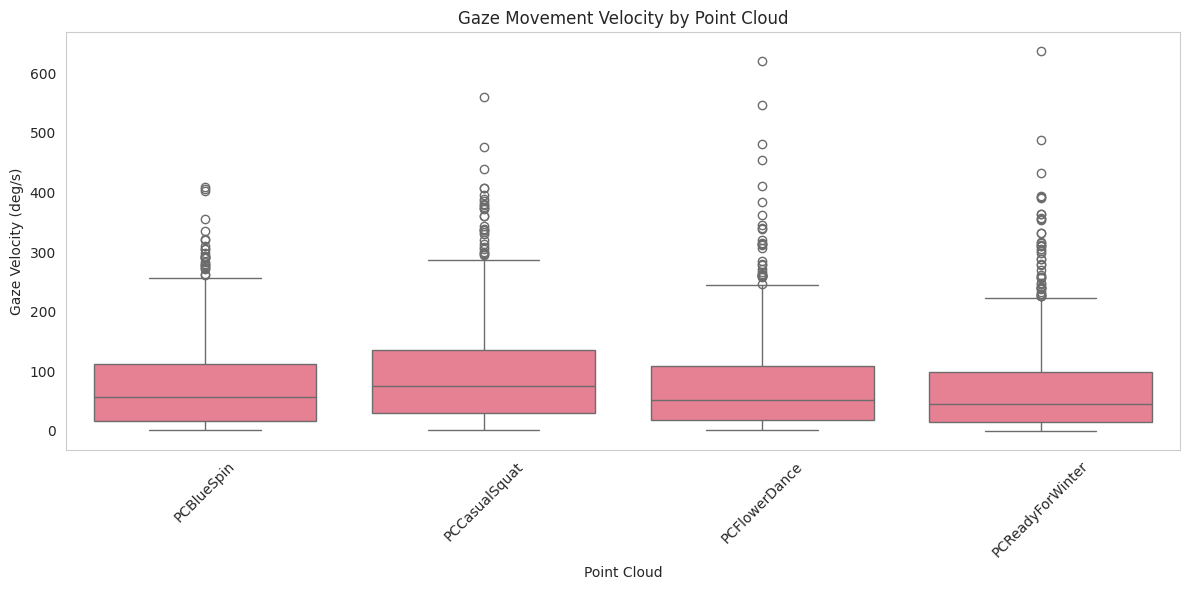

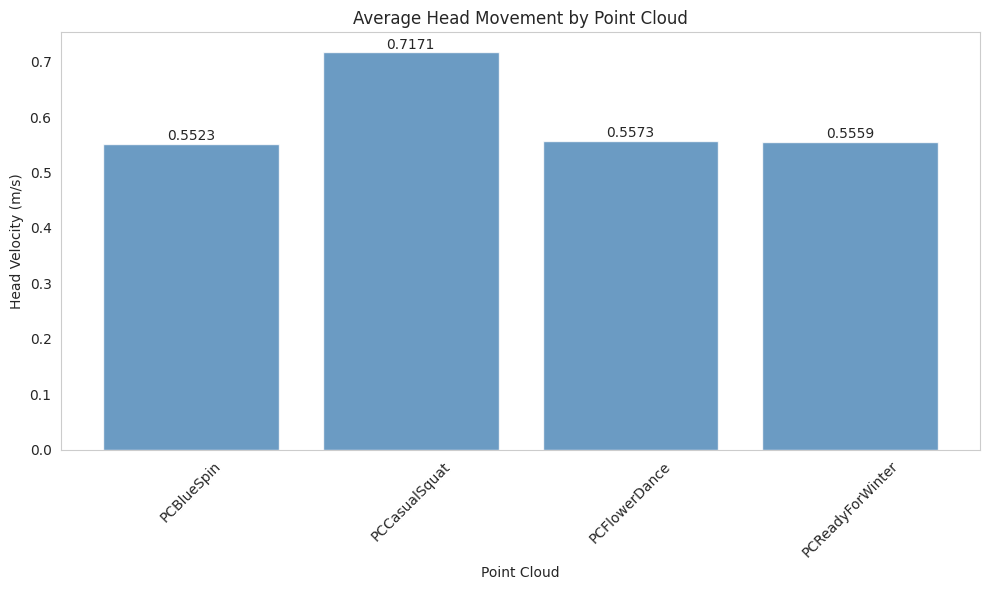

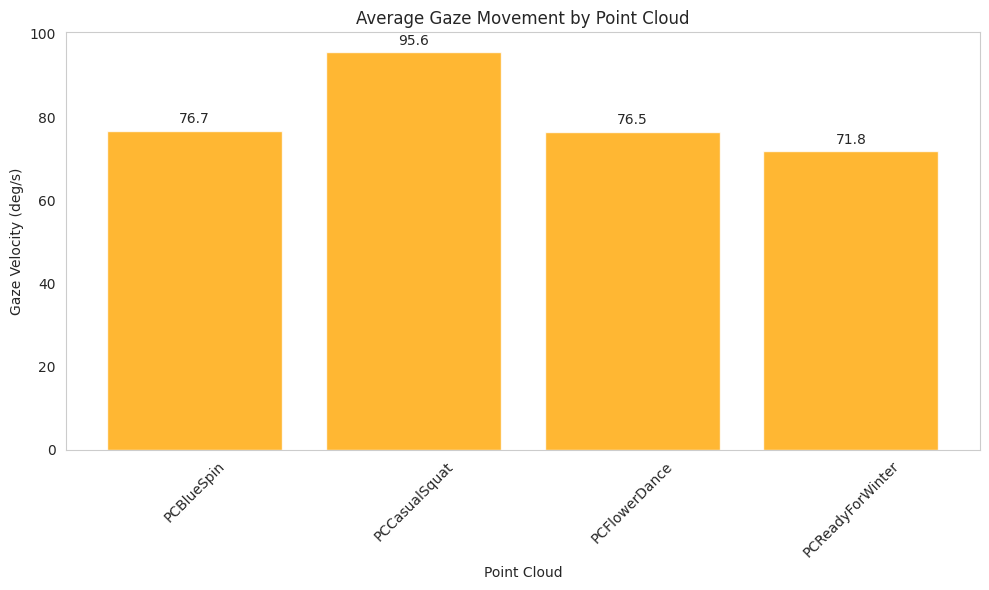


Point clouds ranked by head movement (highest to lowest):
1. PCCasualSquat: 0.7171 m/s
2. PCFlowerDance: 0.5573 m/s
3. PCReadyForWinter: 0.5559 m/s
4. PCBlueSpin: 0.5523 m/s

Point clouds ranked by gaze movement (highest to lowest):
1. PCCasualSquat: 95.6 deg/s
2. PCBlueSpin: 76.7 deg/s
3. PCFlowerDance: 76.5 deg/s
4. PCReadyForWinter: 71.8 deg/s


In [14]:
# Plot movement analysis by point cloud type

# Head movement by point cloud - Box plot
plt.figure(figsize=(12, 6))
sns.boxplot(data=velocity_df, x='pc_name', y='head_velocity_m_per_s')
plt.title('Head Movement Velocity by Point Cloud')
plt.xlabel('Point Cloud')
plt.ylabel('Head Velocity (m/s)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig(os.path.join(results_dir, 'head_movement_by_pointcloud_boxplot.png'), dpi=300, bbox_inches='tight')
plt.show()

# Gaze movement by point cloud - Box plot
plt.figure(figsize=(12, 6))
sns.boxplot(data=velocity_df, x='pc_name', y='gaze_velocity_deg_per_s')
plt.title('Gaze Movement Velocity by Point Cloud')
plt.xlabel('Point Cloud')
plt.ylabel('Gaze Velocity (deg/s)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig(os.path.join(results_dir, 'gaze_movement_by_pointcloud_boxplot.png'), dpi=300, bbox_inches='tight')
plt.show()

# Average head movement by point cloud - Bar chart
plt.figure(figsize=(10, 6))
pc_means = velocity_df.groupby('pc_name').agg({
    'head_velocity_m_per_s': 'mean',
    'gaze_velocity_deg_per_s': 'mean'
}).reset_index()

bars1 = plt.bar(pc_means['pc_name'], pc_means['head_velocity_m_per_s'], 
                alpha=0.8, color='steelblue')
plt.xlabel('Point Cloud')
plt.ylabel('Head Velocity (m/s)')
plt.title('Average Head Movement by Point Cloud')
plt.xticks(rotation=45)

# Add value labels
for bar in bars1:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.001,
             f'{height:.4f}', ha='center', va='bottom', fontsize=10)
plt.tight_layout()
plt.savefig(os.path.join(results_dir, 'average_head_movement_by_pointcloud.png'), dpi=300, bbox_inches='tight')
plt.show()

# Average gaze movement by point cloud - Bar chart
plt.figure(figsize=(10, 6))
bars2 = plt.bar(pc_means['pc_name'], pc_means['gaze_velocity_deg_per_s'], 
                alpha=0.8, color='orange')
plt.xlabel('Point Cloud')
plt.ylabel('Gaze Velocity (deg/s)')
plt.title('Average Gaze Movement by Point Cloud')
plt.xticks(rotation=45)

# Add value labels
for bar in bars2:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 1,
             f'{height:.1f}', ha='center', va='bottom', fontsize=10)
plt.tight_layout()
plt.savefig(os.path.join(results_dir, 'average_gaze_movement_by_pointcloud.png'), dpi=300, bbox_inches='tight')
plt.show()

# Rank point clouds by movement
pc_rankings = pc_means.sort_values('head_velocity_m_per_s', ascending=False)
print("\nPoint clouds ranked by head movement (highest to lowest):")
for i, (_, row) in enumerate(pc_rankings.iterrows(), 1):
    print(f"{i}. {row['pc_name']}: {row['head_velocity_m_per_s']:.4f} m/s")

pc_rankings_gaze = pc_means.sort_values('gaze_velocity_deg_per_s', ascending=False)
print("\nPoint clouds ranked by gaze movement (highest to lowest):")
for i, (_, row) in enumerate(pc_rankings_gaze.iterrows(), 1):
    print(f"{i}. {row['pc_name']}: {row['gaze_velocity_deg_per_s']:.1f} deg/s")

In [15]:
# Save detailed results to CSV files
print("Saving detailed results...")

# 1. User classifications
user_classifications.to_csv(os.path.join(results_dir, 'user_movement_classifications.csv'), index=False)

# 2. Velocity data with categories
velocity_with_categories.to_csv(os.path.join(results_dir, 'velocity_data_with_categories.csv'), index=False)

# 3. Summary statistics by category
category_summary = velocity_with_categories.groupby('overall_movement_category').agg({
    'head_velocity_m_per_s': ['count', 'mean', 'std', 'min', 'max'],
    'gaze_velocity_deg_per_s': ['count', 'mean', 'std', 'min', 'max']
}).round(6)
category_summary.to_csv(os.path.join(results_dir, 'movement_summary_by_category.csv'))

# 4. Summary statistics by point cloud
pc_summary = velocity_df.groupby('pc_name').agg({
    'head_velocity_m_per_s': ['count', 'mean', 'std', 'min', 'max'],
    'gaze_velocity_deg_per_s': ['count', 'mean', 'std', 'min', 'max']
}).round(6)
pc_summary.to_csv(os.path.join(results_dir, 'movement_summary_by_pointcloud.csv'))

# 5. Correlation analysis results (updated with both Pearson and Spearman)
correlation_results = pd.DataFrame({
    'Category': ['Overall'] + categories,
    'Pearson_Correlation': [pearson_corr] + pearson_correlations,
    'Spearman_Correlation': [spearman_corr] + spearman_correlations,
    'Sample_Size': [len(velocity_df)] + [len(velocity_with_categories[velocity_with_categories['overall_movement_category'] == cat]) for cat in categories]
})
correlation_results.to_csv(os.path.join(results_dir, 'head_gaze_correlations.csv'), index=False)

# 6. Statistical test results
statistical_results = pd.DataFrame({
    'Test': ['Head Movement ANOVA', 'Gaze Movement ANOVA'],
    'F_Statistic': [f_stat_head, f_stat_gaze],
    'P_Value': [p_val_head, p_val_gaze],
    'Significant': [p_val_head < 0.05, p_val_gaze < 0.05]
})
statistical_results.to_csv(os.path.join(results_dir, 'statistical_test_results.csv'), index=False)

print("Results saved to the following files:")
for file in ['user_movement_classifications.csv', 'velocity_data_with_categories.csv', 
             'movement_summary_by_category.csv', 'movement_summary_by_pointcloud.csv',
             'head_gaze_correlations.csv', 'statistical_test_results.csv']:
    print(f"- {file}")

Saving detailed results...
Results saved to the following files:
- user_movement_classifications.csv
- velocity_data_with_categories.csv
- movement_summary_by_category.csv
- movement_summary_by_pointcloud.csv
- head_gaze_correlations.csv
- statistical_test_results.csv


In [16]:
# Generate comprehensive summary report
print("=" * 80)
print("EYE-TRACKING DATA ANALYSIS SUMMARY REPORT")
print("=" * 80)

print(f"\n1. DATA OVERVIEW:")
print(f"   - Total users analyzed: {velocity_df['user_id'].nunique()}")
print(f"   - Point clouds: {', '.join(velocity_df['pc_name'].unique())}")
print(f"   - Total data points: {len(velocity_df)} (after discarding first {INITIAL_DISCARD_TIME}s)")
print(f"   - Frame rate: {FRAME_RATE} fps")

print(f"\n2. OVERALL MOVEMENT STATISTICS:")
print(f"   Head Movement:")
print(f"     - Mean: {velocity_df['head_velocity_m_per_s'].mean():.4f} ± {velocity_df['head_velocity_m_per_s'].std():.4f} m/s")
print(f"     - Median: {velocity_df['head_velocity_m_per_s'].median():.4f} m/s")
print(f"     - Range: {velocity_df['head_velocity_m_per_s'].min():.4f} - {velocity_df['head_velocity_m_per_s'].max():.4f} m/s")

print(f"   Gaze Movement:")
print(f"     - Mean: {velocity_df['gaze_velocity_deg_per_s'].mean():.1f} ± {velocity_df['gaze_velocity_deg_per_s'].std():.1f} deg/s")
print(f"     - Median: {velocity_df['gaze_velocity_deg_per_s'].median():.1f} deg/s")
print(f"     - Range: {velocity_df['gaze_velocity_deg_per_s'].min():.1f} - {velocity_df['gaze_velocity_deg_per_s'].max():.1f} deg/s")

print(f"\n3. USER CLASSIFICATION (by percentiles):")
classification_counts = user_classifications['head_movement_category'].value_counts()
for category in CATEGORY_ORDER:
    count = classification_counts.get(category, 0)
    percentage = (count / len(user_classifications)) * 100
    print(f"   {category} Movement: {count} users ({percentage:.1f}%)")

print(f"\n4. HEAD-GAZE MOVEMENT CORRELATION:")
print(f"   - Overall Pearson correlation: {pearson_corr:.4f} (p={pearson_p:.6f})")
print(f"   - Overall Spearman correlation: {spearman_corr:.4f} (p={spearman_p:.6f})")
print("   By category:")
for category, pearson_corr_cat, spearman_corr_cat in zip(categories, pearson_correlations, spearman_correlations):
    print(f"     - {category} movement users - Pearson: {pearson_corr_cat:.4f}, Spearman: {spearman_corr_cat:.4f}")

print(f"\n5. MOVEMENT BY POINT CLOUD TYPE:")
print(f"   Head Movement Ranking (highest to lowest):")
for i, (_, row) in enumerate(pc_rankings.iterrows(), 1):
    print(f"     {i}. {row['pc_name']}: {row['head_velocity_m_per_s']:.4f} m/s")

print(f"   Gaze Movement Ranking (highest to lowest):")
for i, (_, row) in enumerate(pc_rankings_gaze.iterrows(), 1):
    print(f"     {i}. {row['pc_name']}: {row['gaze_velocity_deg_per_s']:.1f} deg/s")

print(f"\n6. STATISTICAL SIGNIFICANCE:")
print(f"   - Head movement differences between point clouds: {'Significant' if p_val_head < 0.05 else 'Not significant'} (p={p_val_head:.6f})")
print(f"   - Gaze movement differences between point clouds: {'Significant' if p_val_gaze < 0.05 else 'Not significant'} (p={p_val_gaze:.6f})")

print(f"\n7. KEY FINDINGS:")
if p_val_head < 0.05 or p_val_gaze < 0.05:
    print(f"   - Users show different movement patterns depending on the point cloud content")
    if pc_rankings.iloc[0]['head_velocity_m_per_s'] > pc_rankings.iloc[-1]['head_velocity_m_per_s'] * 1.2:
        print(f"   - '{pc_rankings.iloc[0]['pc_name']}' elicits the most head movement")
        print(f"   - '{pc_rankings.iloc[-1]['pc_name']}' elicits the least head movement")
else:
    print(f"   - No significant differences in movement patterns between point clouds")

if pearson_corr > 0.5:
    print(f"   - Strong positive correlation between head and gaze movements (Pearson)")
elif pearson_corr > 0.3:
    print(f"   - Moderate positive correlation between head and gaze movements (Pearson)")
else:
    print(f"   - Weak correlation between head and gaze movements (Pearson)")

print(f"\n8. GENERATED FILES:")
generated_files = [
    # Figure files
    "head_movement_average.png",
    "head_movement_distribution.png",
    "gaze_movement_average.png",
    "gaze_movement_distribution.png",
    "head_movement_classification.png", 
    "gaze_movement_classification.png",
    "head_vs_gaze_scatter.png",
    "average_head_velocity_by_category.png",
    "average_gaze_velocity_by_category.png",
    "head_movement_over_time_by_category.png",
    "gaze_movement_over_time_by_category.png",
    "head_velocity_distribution_by_category.png",
    "gaze_velocity_distribution_by_category.png",
    "head_vs_gaze_overall_correlation.png",
    "head_vs_gaze_by_category.png",
    "correlation_by_category.png",
    "summary_statistics_table.png",
    "head_movement_by_pointcloud_boxplot.png",
    "gaze_movement_by_pointcloud_boxplot.png",
    "average_head_movement_by_pointcloud.png",
    "average_gaze_movement_by_pointcloud.png",
    # CSV files
    "user_movement_classifications.csv",
    "velocity_data_with_categories.csv",
    "movement_summary_by_category.csv", 
    "movement_summary_by_pointcloud.csv",
    "head_gaze_correlations.csv",
    "statistical_test_results.csv"
]

for file in generated_files:
    print(f"   - {file}")

print(f"\n" + "=" * 80)
print("Analysis completed successfully!")
print(f"All results saved in '{results_dir}' folder")
print("=" * 80)

EYE-TRACKING DATA ANALYSIS SUMMARY REPORT

1. DATA OVERVIEW:
   - Total users analyzed: 41
   - Point clouds: PCBlueSpin, PCCasualSquat, PCFlowerDance, PCReadyForWinter
   - Total data points: 3103 (after discarding first 1.5s)
   - Frame rate: 25 fps

2. OVERALL MOVEMENT STATISTICS:
   Head Movement:
     - Mean: 0.5958 ± 0.5876 m/s
     - Median: 0.4368 m/s
     - Range: 0.0036 - 6.3352 m/s
   Gaze Movement:
     - Mean: 80.2 ± 79.4 deg/s
     - Median: 58.1 deg/s
     - Range: 0.6 - 636.9 deg/s

3. USER CLASSIFICATION (by percentiles):
   Low Movement: 11 users (26.8%)
   Medium Movement: 19 users (46.3%)
   High Movement: 11 users (26.8%)

4. HEAD-GAZE MOVEMENT CORRELATION:
   - Overall Pearson correlation: 0.7105 (p=0.000000)
   - Overall Spearman correlation: 0.7775 (p=0.000000)
   By category:
     - Low movement users - Pearson: 0.7672, Spearman: 0.8019
     - Medium movement users - Pearson: 0.6378, Spearman: 0.7244
     - High movement users - Pearson: 0.7076, Spearman: 0.771